In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Loading Dataset**

In [ ]:
# example of preparing the horses and zebra dataset
import os
from os import listdir
import numpy as np
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)
 
# dataset path
path = "/content/drive/My Drive/Project_Cycle_Gan/original_images/"
# load dataset A
dataA = load_images(path + 'trainA/')
dataA_test = load_images(path + 'testA/')
print('Loaded dataA: ', dataA.shape)
print('Loaded dataA_test: ', dataA_test.shape)
# load dataset B
dataB = load_images(path + 'trainB/')
print('Loaded dataA: ', dataB.shape)
# save as compressed numpy array
filename = "/content/drive/My Drive/Project_Cycle_Gan/compressed_data/data.npz"
savez_compressed(filename, dataA, dataB,dataA_test)
print('Saved dataset: ', filename)

Using TensorFlow backend.


Loaded dataA:  (902, 256, 256, 3)
Loaded dataA_test:  (1977, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 28 bytes but only got 26. Skipping tag 50341
  " Skipping tag %s" % (size, len(data), tag)


Loaded dataA:  (825, 256, 256, 3)
Saved dataset:  /content/drive/My Drive/Project_Cycle_Gan/compressed_data/data.npz


Loaded:  (902, 256, 256, 3) (825, 256, 256, 3)


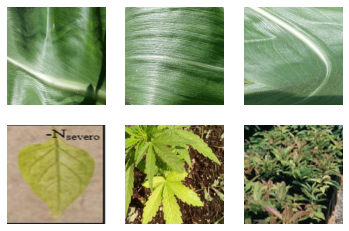

In [ ]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load("/content/drive/My Drive/Project_Cycle_Gan/compressed_data/data.npz")
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

**Creating Model**

In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fqk1xmbj
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fqk1xmbj
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=94a9fa95c9175b57679a6794ce8b3c6f85a526ed251323150f6fa245386bd948
  Stored in directory: /tmp/pip-ephem-wheel-cache-stxrlhcj/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
import pickle
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B):

	# save the first generator model
	#filename1 = 'g_model_AtoB.h5' % (step+1)

  g_model_AtoB.save('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_A2B.h5')
  # save the second generator model
	#filename2 = 'g_model_BtoA.h5' % (step+1)
  g_model_BtoA.save('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_B2A.h5')
  d_model_B.save('/content/drive/My Drive/Project_Cycle_Gan/models/d_model_B.h5')
  d_model_A.save('/content/drive/My Drive/Project_Cycle_Gan/models/d_model_A.h5')
 

  #print("Here are 4 models are getting saved no matter what is getting printed below :)")
  print('DONE HERE')


In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
  images_dir = '/content/drive/My Drive/Project_Cycle_Gan/output_images/'
	# select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
	# plot real images
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_in[i])
	# plot translated image
  for i in range(n_samples):
	  pyplot.subplot(2, n_samples, 1 + n_samples + i)
	  pyplot.axis('off')
	  pyplot.imshow(X_out[i])
	# save plot to file
  filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
  pyplot.savefig(images_dir+filename1)
  pyplot.close()
 

In [ ]:
def update_image_pool(pool, images, x,max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
			# stock the pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
			# use image, but don't add it to the pool
      selected.append(image)
    else:
			# replace an existing image and use replaced image
      ix = randint(0, len(pool))
      selected.append(pool[ix])
      pool[ix] = image
  with open('/content/drive/My Drive/Project_Cycle_Gan/pools/'+x+'.txt', 'wb') as f:
    pickle.dump(pool, f)
  return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,poolA,poolB):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = poolA,poolB
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA,"A")
		X_fakeB = update_image_pool(poolB, X_fakeB,"B")
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (250 * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (250 * 1)  == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B)

In [ ]:
dataset = load_real_samples("/content/drive/My Drive/Project_Cycle_Gan/compressed_data/data.npz")
print('Loaded:', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,list(),list())

Loaded: (902, 256, 256, 3) (825, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[1.085,0.887] dB[1.636,0.778] g[18.726,18.052]
>2, dA[5.631,0.909] dB[2.383,0.977] g[18.498,17.446]
>3, dA[5.431,0.922] dB[3.547,2.125] g[17.766,18.670]
>4, dA[2.459,1.705] dB[1.043,4.903] g[18.826,20.786]
>5, dA[12.258,3.559] dB[3.231,8.946] g[26.587,19.206]
>6, dA[5.406,2.335] dB[1.501,5.233] g[19.685,19.091]
>7, dA[6.849,1.320] dB[2.184,3.873] g[21.995,19.823]
>8, dA[3.027,0.765] dB[3.605,1.647] g[16.918,16.599]
>9, dA[0.997,0.683] dB[1.368,1.335] g[16.104,15.486]
>10, dA[1.010,0.996] dB[0.879,1.132] g[14.149,14.396]
>11, dA[0.597,1.217] dB[1.324,0.983] g[14.146,15.014]
>12, dA[0.702,0.928] dB[0.819,1.029] g[11.576,10.977]
>13, dA[0.643,0.764] dB[0.681,0.933] g[15.155,16.451]
>14, dA[0.680,0.664] dB[0.599,0.646] g[12.395,12.639]
>15, dA[0.709,0.657] dB[0.560,1.086] g[14.130,14.521]
>16, dA[0.697,0.782] dB[0.559,0.888] g[16.371,15.735]
>17, dA[0.676,0.608] dB[0.601,0.620] g[11.304,11.228]
>18, dA[0.993,0.824] dB[0.513,0.978] g[16.039,15.831]
>19, dA[0.653,0.767] dB[0.624,0.927]

KeyboardInterrupt: ignored

**Retraining Code**

In [ ]:
from numpy import load
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
with open('/content/drive/My Drive/Project_Cycle_Gan/pools/A.txt', "rb") as fp:   # Unpickling   
  poolA = pickle.load(fp)
with open('/content/drive/My Drive/Project_Cycle_Gan/pools/B.txt', "rb") as fp:   # Unpickling   
  poolB = pickle.load(fp) 
# generator: A -> B
g_model_AtoB = load_model('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_A2B.h5',cust)
# generator: B -> A
g_model_BtoA = load_model('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_B2A.h5',cust)
# discriminator: A -> [real/fake]
d_model_A =  load_model('/content/drive/My Drive/Project_Cycle_Gan/models/d_model_A.h5',cust)
# discriminator: B -> [real/fake]
d_model_B =  load_model('/content/drive/My Drive/Project_Cycle_Gan/models/d_model_B.h5',cust)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,poolA,poolB)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.071,0.083] dB[0.084,0.055] g[6.114,6.077]
>2, dA[0.051,0.136] dB[0.317,0.328] g[8.763,9.800]
>3, dA[0.374,0.054] dB[0.053,0.113] g[7.708,8.304]
>4, dA[0.094,0.171] dB[0.217,0.092] g[7.921,7.694]
>5, dA[0.040,0.025] dB[0.110,0.082] g[5.579,5.525]
>6, dA[0.307,0.188] dB[0.027,0.150] g[5.923,8.851]
>7, dA[0.029,0.053] dB[0.335,0.102] g[7.106,6.976]
>8, dA[0.171,0.161] dB[0.273,0.283] g[7.458,8.300]
>9, dA[0.041,0.050] dB[0.161,0.080] g[11.956,13.027]
>10, dA[0.027,0.042] dB[0.080,0.074] g[9.240,11.079]
>11, dA[0.025,0.033] dB[0.044,0.087] g[9.173,10.925]
>12, dA[0.419,0.097] dB[0.061,0.018] g[7.441,7.855]
>13, dA[0.055,0.187] dB[0.037,0.034] g[14.991,12.228]
>14, dA[0.167,0.082] dB[0.412,0.067] g[6.138,5.613]
>15, dA[0.036,0.027] dB[0.052,0.034] g[8.961,10.114]
>16, dA[0.204,0.028] dB[0.036,0.026] g[6.648,7.362]
>17, dA[0.043,0.123] dB[0.185,0.096] g[7.393,7.014]
>18, dA[0.013,0.016] dB[0.084,0.127] g[9.092,11.829]
>19, dA[0.144,0.112] dB[0.020,0.116] g[8.606,7.954]
>20, dA[0.013

**Testing Code**

In [ ]:
def load_test_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1 = data['arr_2']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	return [X1]

Loaded: (120, 256, 256, 3) (140, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


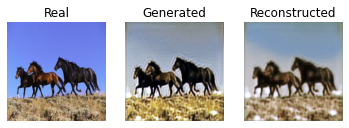

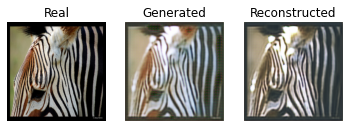

In [ ]:
from numpy import load
from keras.models import load_model
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
cust = {'InstanceNormalization': InstanceNormalization}
test_A = load_test_samples("/content/drive/My Drive/Project_Cycle_Gan/compressed_data/data.npz")
print('Loaded:', test_A.shape, test_B.shape)
# generator: A -> B
g_model_AtoB = load_model('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_A2B.h5',cust)
# generator: B -> A
g_model_BtoA = load_model('/content/drive/My Drive/Project_Cycle_Gan/models/generator_model_B2A.h5',cust)
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()
 # plot A->B->A
A_real = select_sample(test_A, 1)
B_generated  = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)